# Анализ оттока клиентов сети фитнес-центров

**Цель исследования**:

1. Провести анализ оттока клиентов сети фитнес-центров «Культурист-датасаентист».
2. Сформулировать выводы и сделать базовые рекомендации по удержанию клиентов.

  **Ход исследования:**
    Данные я получу из файла `/datasets/gym_churn.csv`. О качестве данных ничего не известно. Поэтому перед тем, как приступать к целям исследования, понадобится обзор данных.
    
    Я проверю данные на ошибки и оценю их влияние на исследование. Затем, на этапе предобработки я поищу возможность исправить все ошибки данных, которые не приведут к искажению конечного результата. Далее, приступлю к исследовательскому анализу данных. Затем на основании полученных данных построю модели прогнозирования оттока клиентов и кластеризации клиентов.
    
    Таким образом, мое исследование пройдет в пять этапов:
    - Обзор и предобработка данных.
    - Проведение исследовательского анализа данных
    - Построение модели прогнозирования оттока клиентов
    - Проведение кластеризации клиентов
    - Подготовка рекомендаций по работе с клиентами

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from matplotlib import rcParams
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format='{:,.2f}'.format
rcParams['figure.figsize'] = 8, 5

## Загрузка, обзор и предобработка данных

In [ ]:
try:
    data = pd.read_csv('/datasets/gym_churn.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net//datasets/gym_churn.csv')

In [ ]:
display(data.head())
data.info()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

*В представленных данных есть информация о 4000 посетителях сети фитнес-центров с указанием анкетных данных (`gender, near_location, partner, promo_friends, phone, age`), информации на основе журналов посещений тренировок (`contract_period, group_visits, avg_additional_charges_total, month_to_end_contract, lifetime, avg_class_frequency_total, avg_class_frequency_current_month`), покупок допуслуг фитнес-центра и данные о текущем статусе клиента (`churn`).*

In [ ]:
# приведем наименования столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [ ]:
# изучим пропуски в данных
data.isna().sum()

,0
gender,0
near_location,0
partner,0
promo_friends,0
phone,0
contract_period,0
group_visits,0
age,0
avg_additional_charges_total,0
month_to_end_contract,0


In [ ]:
# проверим датафрейм на явные дубликаты
data.duplicated().sum()

np.int64(0)

*Установлено отсутствие пропусков и дубликатов в данных.*

**Вывод по разделу "Загрузка, обзор и предобработка данных":**
1. В представленных данных есть информация о 4000 посетителях сети фитнес-центров с указанием анкетных данных, информации на основе журналов посещений тренировок, покупок допуслуг фитнес-центра и данные о текущем статусе клиента.
2. Наименования столбцов датафреймов приведены к формату нижнего регистра
3. Установлено отсутствие пропусков и дубликатов в данных.

## Проведение исследовательского анализа данных (EDA)

### Изучим средние значения и стандартные отклонения логических и числовых признаков

In [ ]:
# изучим средние значения и стандартные отклонения признаков с логическим типом данных
data[[
    'gender',
    'near_location',
    'partner',
    'promo_friends',
    'phone',
    'group_visits',
    'churn']].describe().loc[['mean', 'std']]

,gender,near_location,partner,promo_friends,phone,group_visits,churn
mean,0.51,0.85,0.49,0.31,0.90,0.41,0.27
std,0.50,0.36,0.50,0.46,0.30,0.49,0.44


*Среди попавших в выборку клиентов:*

*- примерно пополам мужчин (51%) и женщин (49%),*

*- проживающих вблизи спортклуба - 85%,*

*- сотрудники компаний-партнеров - 49%,*

*- воспользовавшихся скидкой по акции "приведи друга" - 31%,*

*- указавших в анкете номер телефона - 90%,*

*- посещающих групповые занятия - 41%*

*- бросили занятия (попали в отток) - 27%*

In [ ]:
# изучим средние значения и стандартные отклонения числовых признаков
data[[
    'age',
    'lifetime',
    'contract_period',
    'month_to_end_contract',
    'avg_additional_charges_total',
    'avg_class_frequency_total',
    'avg_class_frequency_current_month']].describe().loc[['min', 'max', 'mean', 'std']]

,age,lifetime,contract_period,month_to_end_contract,avg_additional_charges_total,avg_class_frequency_total,avg_class_frequency_current_month
min,18.00,0.00,1.00,1.00,0.15,0.00,0.00
max,41.00,31.00,12.00,12.00,552.59,6.02,6.15
mean,29.18,3.72,4.68,4.32,146.94,1.88,1.77
std,3.26,3.75,4.55,4.19,96.36,0.97,1.05


*Среди попавших в выборку клиентов:*

*- cредний возраст клиентов 29,2 лет с небольшим разбросом значений (std 3,3 года),*

*- средняя продолжительность посещения клуба 3,7 мес. с большим разбросом значений от 0 до 31 мес. (std 3,8 мес.),*

*- средняя длительность текущих абонементов - 4,7 мес. (std 4,6 мес.)*

*- средняя продолжительность периодов до конца действия абонементов - 4,3 мес. (std 4,2 мес.)*

*- средняя суммарная стоимость дополнительных услуг - 146,9 руб. (std 96,36 руб.)*

*- средняя частота посещений - 1,9 зан./нед. с большим разбросом значений от 0 до 6 раз (std 1 раз в неделю)*

*- средняя частота посещений за последний месяц - 1,8 зан./нед. (std 1 раз в неделю)*

In [ ]:
# сравним средние значения признаков в двух группах: кто ушел в отток и тех, кто остался
data.groupby('churn')[[
    'gender',
    'near_location',
    'partner',
    'promo_friends',
    'phone',
    'group_visits']].mean()

,gender,near_location,partner,promo_friends,phone,group_visits
churn,,,,,,
0,0.51,0.87,0.53,0.35,0.90,0.46
1,0.51,0.77,0.36,0.18,0.90,0.27


*По половому признаку и признаку наличия телефона в анкете нет различий для оттока и неоттока.*

*Есть зависимость оттока от места проживания - из **продолживших занятия**  87% проживают в этом районе, из **ушедших в отток** доля проживающих в этом районе меньше - 77%.*

*Есть зависимость оттока от принадлежности к компании-партнеру - из **продолживших занятия**  53% являются сотрудниками компаний-партнеров, из **ушедших в отток** доля сотрудников меньше - 36%.*

*Есть зависимость оттока от наличия скидки по акции "приведи друга"  - из **продолживших занятия**  35% пришли в зал по акции вслед за другом, из **ушедших в отток** доля меньше - 18%.*

*Есть зависимость оттока от посещения групповых занятий - из **продолживших занятия**  46% посещали группы, из **ушедших в отток** доля меньше - 27%.*

*Можем предположить, что **более склонны к оттоку** клиенты, проживающие в дальних от клуба районах, не являющиеся сотрудниками компаний-партнеров, пришедшие в клуб без друзей и не посещающие групповые тренировки.*

In [ ]:
data.groupby('churn')[[
    'age',
    'lifetime',
    'contract_period',
    'month_to_end_contract',
    'avg_additional_charges_total',
    'avg_class_frequency_total',
    'avg_class_frequency_current_month']].mean()

,age,lifetime,contract_period,month_to_end_contract,avg_additional_charges_total,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,
0,29.98,4.71,5.75,5.28,158.45,2.02,2.03
1,26.99,0.99,1.73,1.66,115.08,1.47,1.04


*Клиенты, бросающие тренировки в среднем моложе на 3 года (27 лет) тех, кто продолжает занятия (30 лет). Их общая продолжительность посещения клуба менее месяца в отличие от оставшихся в клубе со средней продолжительностью около 5 месяцев. Их абонементы краткосрочные - чаще всего на 1 мес., у продолжающих занятия - на 6 мес. Они бросают занятия чаще не использовав абонемент до конца. Их средняя частота посещений 1,5 тренировки в неделю, в последний месяц ходят в среднем только 1 раз. У продолжающих тренировки частота остаеся без изменений - в среднем 2 раза в неделю.*

### Изучим распределения признаков в двух группах: кто ушел в отток и тех, кто остался

In [ ]:
# построим столбчатые диаграммы и диаграммы размаха для дискретных признаков в двух группах: кто ушел в отток и тех, кто остался
discrete_value = [
    'age',
    'lifetime',
    'contract_period',
    'month_to_end_contract'
]

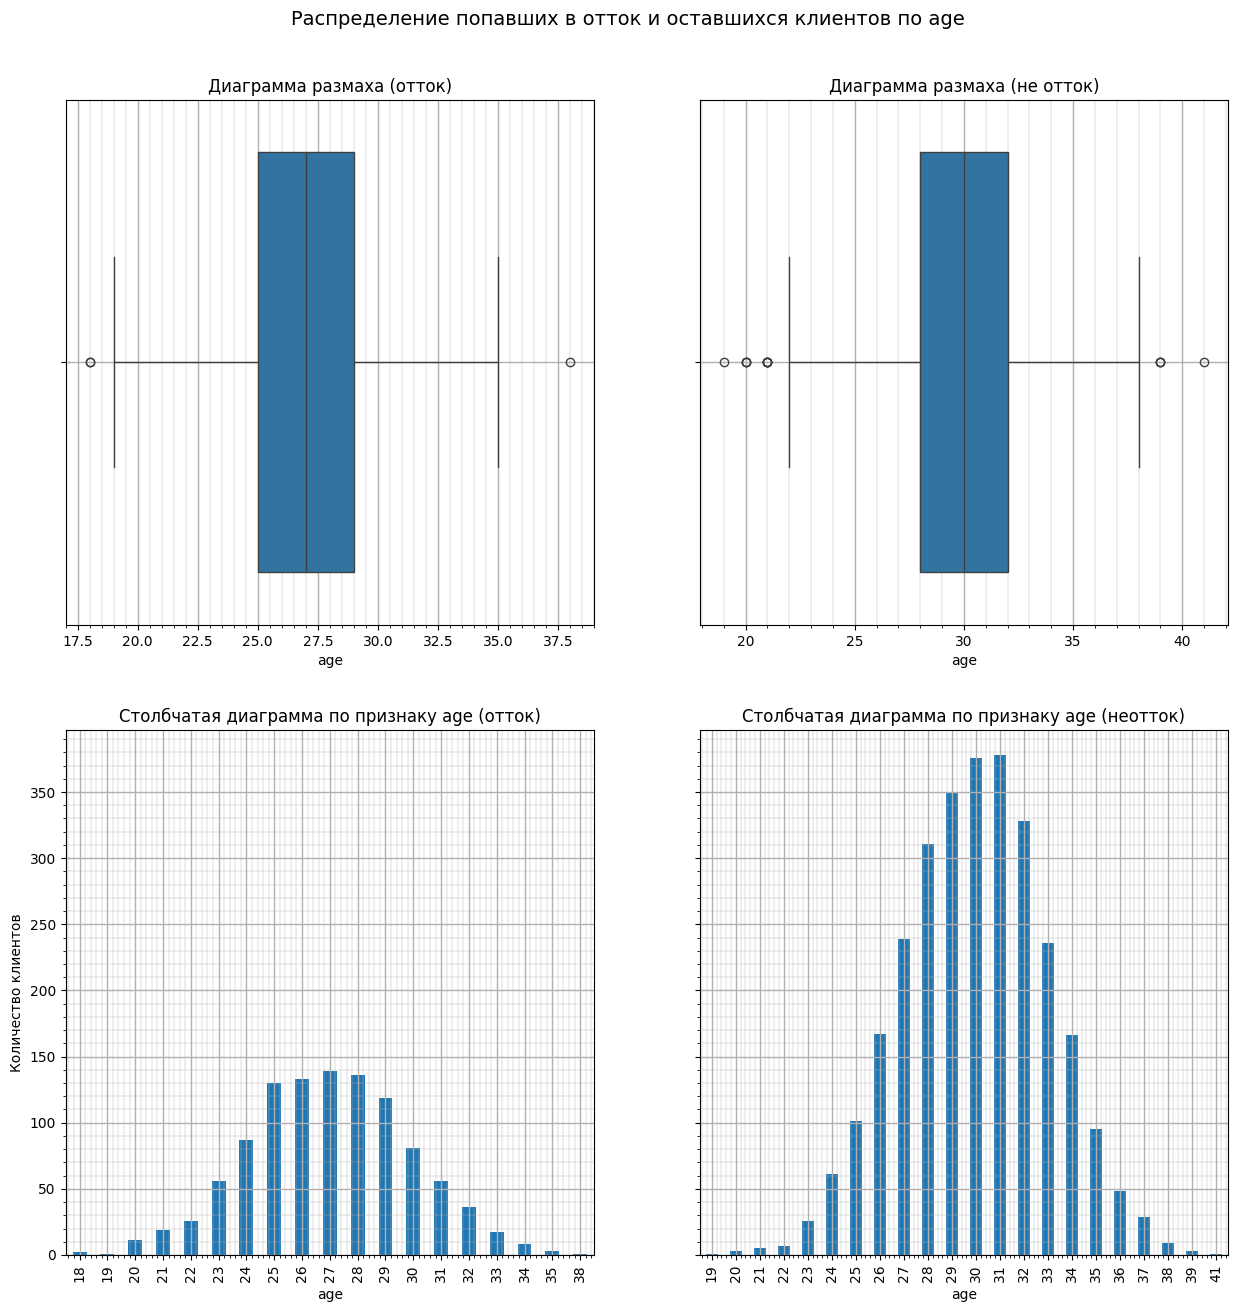

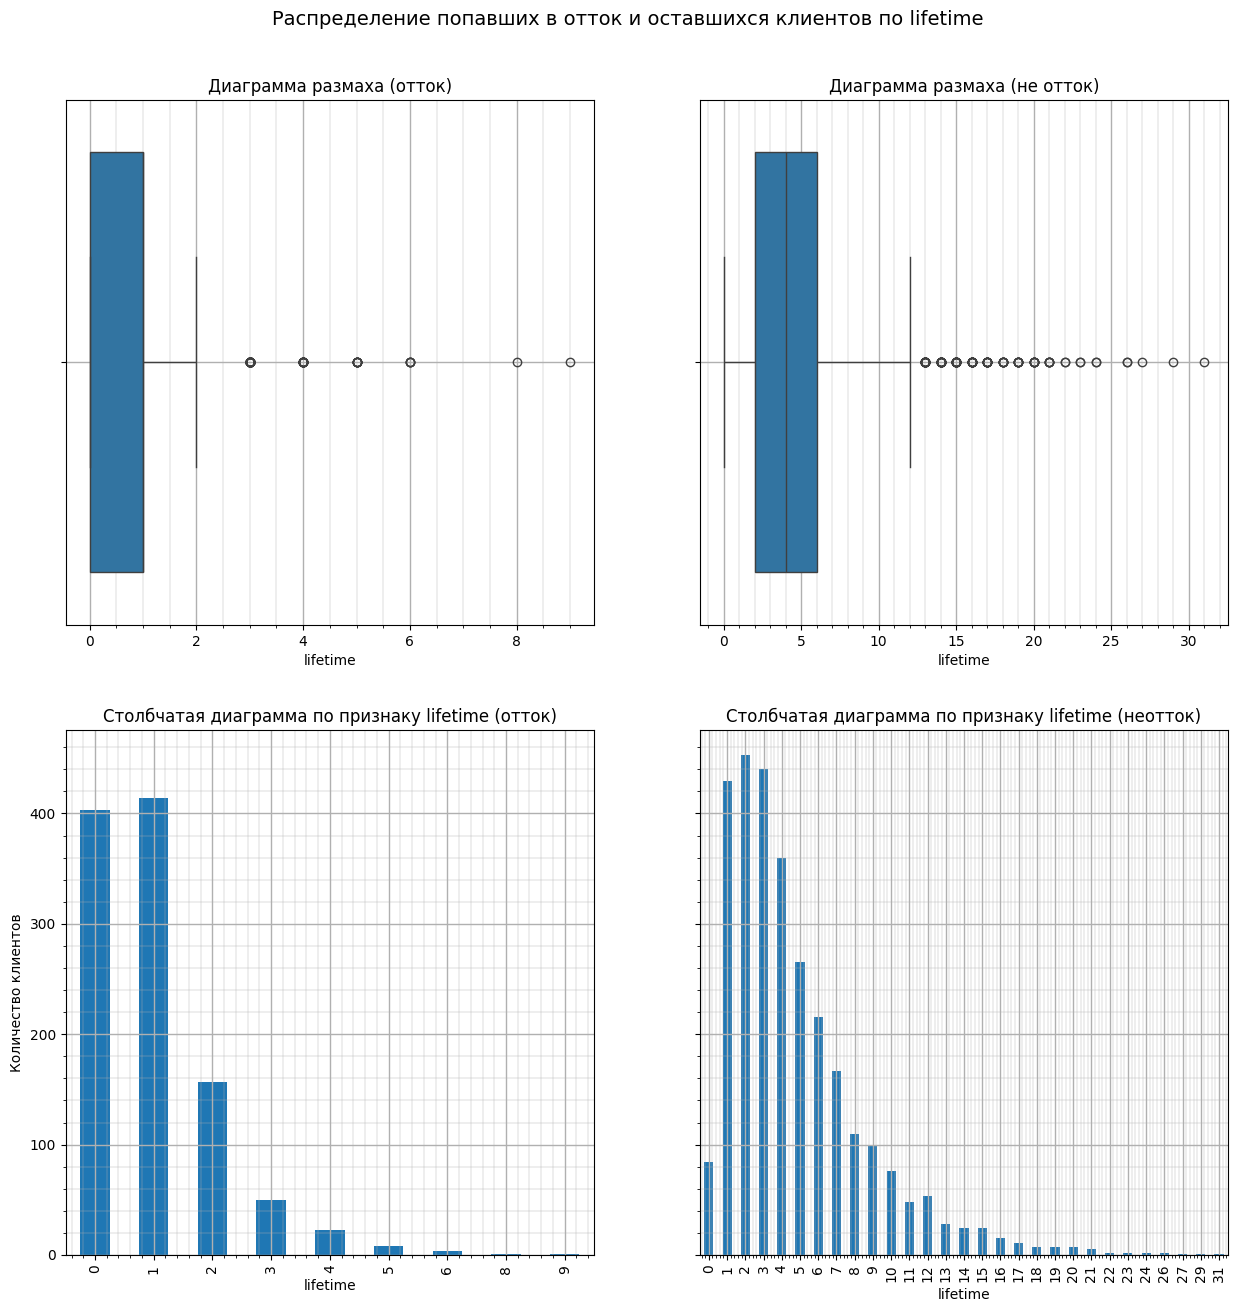

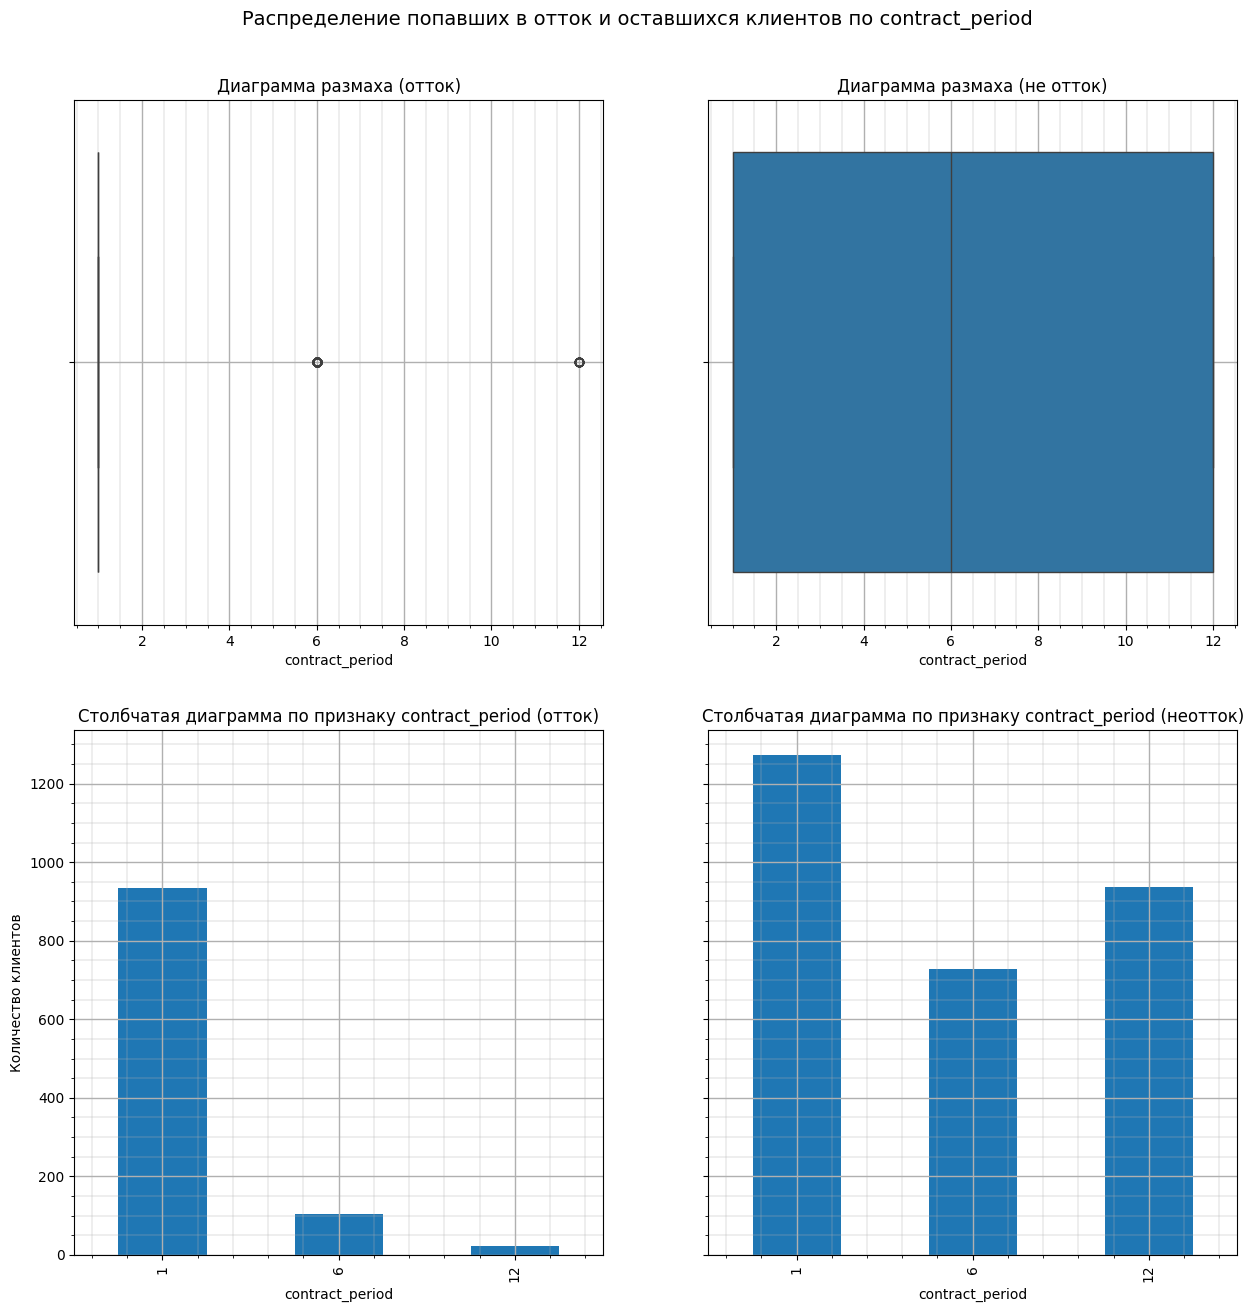

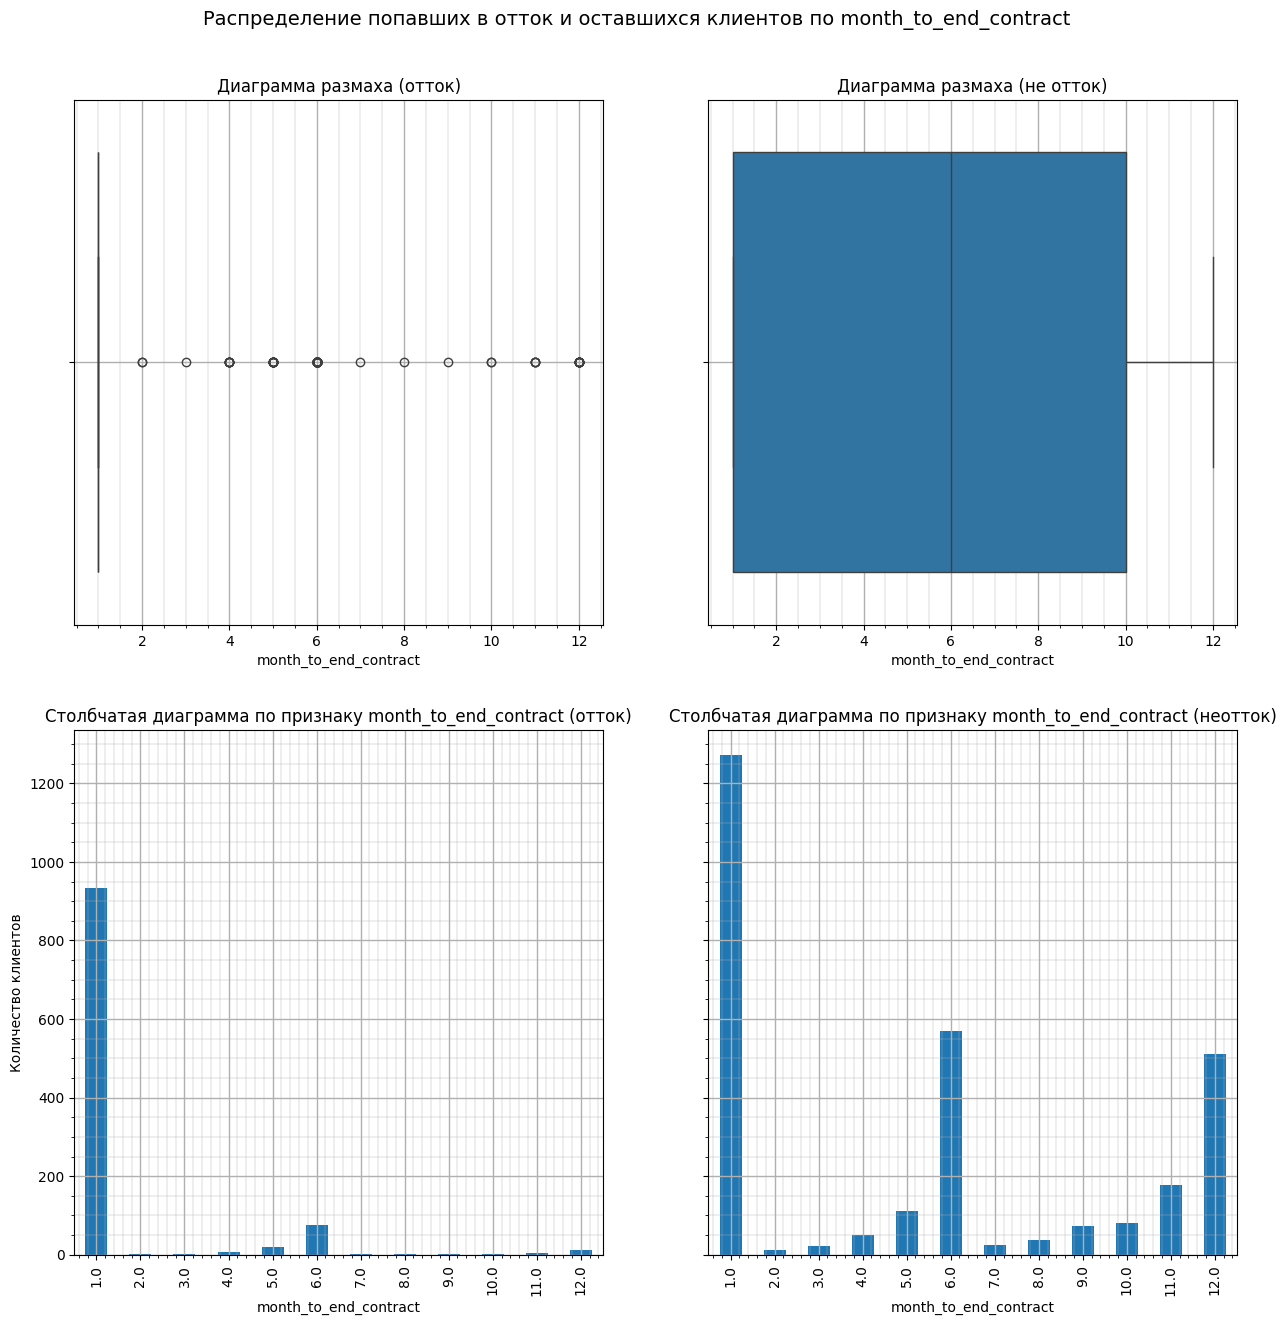

In [ ]:
for feature in discrete_value:
    fig=plt.figure(figsize=(15, 15))
    fig.suptitle(f'Распределение попавших в отток и оставшихся клиентов по {feature}', y=0.94, size=14)

    ax1=plt.subplot(2, 2, 1)
    sns.boxplot(data=data.query('churn==1'), x=feature, ax=ax1)
    ax1.set_title('''Диаграмма размаха (отток)''', size=12)
    ax1.set_xlabel(f'{feature}', size=10)
    ax1.grid(True, which = "major", linewidth = 1)
    ax1.grid(which = "minor", linewidth = 0.3)
    ax1.minorticks_on()

    ax2=plt.subplot(2, 2, 3)
    data.query('churn==1')[feature].value_counts().sort_index().plot.bar(ax=ax2)
    ax2.set_title(f'Столбчатая диаграмма по признаку {feature} (отток)', size=12)
    ax2.set_xlabel(f'{feature}', size=10)
    ax2.set_ylabel('Количество клиентов', size=10)
    ax2.grid(True, which = "major", linewidth = 1)
    ax2.grid(which = "minor", linewidth = 0.3)
    ax2.minorticks_on()

    ax3=plt.subplot(2, 2, 2)
    sns.boxplot(data=data.query('churn==0'), x=feature, ax=ax3)
    ax3.set_title('''Диаграмма размаха (не отток)''', size=12)
    ax3.set_xlabel(f'{feature}', size=10)
    ax3.grid(True, which = "major", linewidth = 1)
    ax3.grid(which = "minor", linewidth = 0.3)
    ax3.minorticks_on()

    ax4=plt.subplot(2, 2, 4, sharey=ax2)
    data.query('churn==0')[feature].value_counts().sort_index().plot.bar(ax=ax4)
    ax4.set_title(f'Столбчатая диаграмма по признаку {feature} (неотток)', size=12)
    ax4.set_xlabel(f'{feature}', size=10)
    ax4.set_ylabel('Количество клиентов', size=10)
    ax4.grid(True, which = "major", linewidth = 1)
    ax4.grid(which = "minor", linewidth = 0.3)
    ax4.minorticks_on()
    plt.show()

*В результате изучения графиков распределения признаков с дисретными величинами аномальные выбросы не выявлены.*

**В отток ушли** *более молодые люди 25-29 лет с общей продолжительностью посещения клуба в течение 1 месяца, с абонементом на 1 месяц и сроком окончания абонемента через 1 месяц.*

**Продолжили занятия в клубе** *клиенты в возрасте 28-32 года, посещающие клуб в течение 2-6 месяцев с приобретенными абонементами как на 1 месяц, так и на 3, и на 6 месяцев, сроки окончания абонементов у этой группы различны.*

In [ ]:
# построим гистограммы и диаграммы размаха для непрерывных величин в двух группах: кто ушел в отток и тех, кто остался
continuous_value = [
    'avg_additional_charges_total',
    'avg_class_frequency_total',
    'avg_class_frequency_current_month'
]

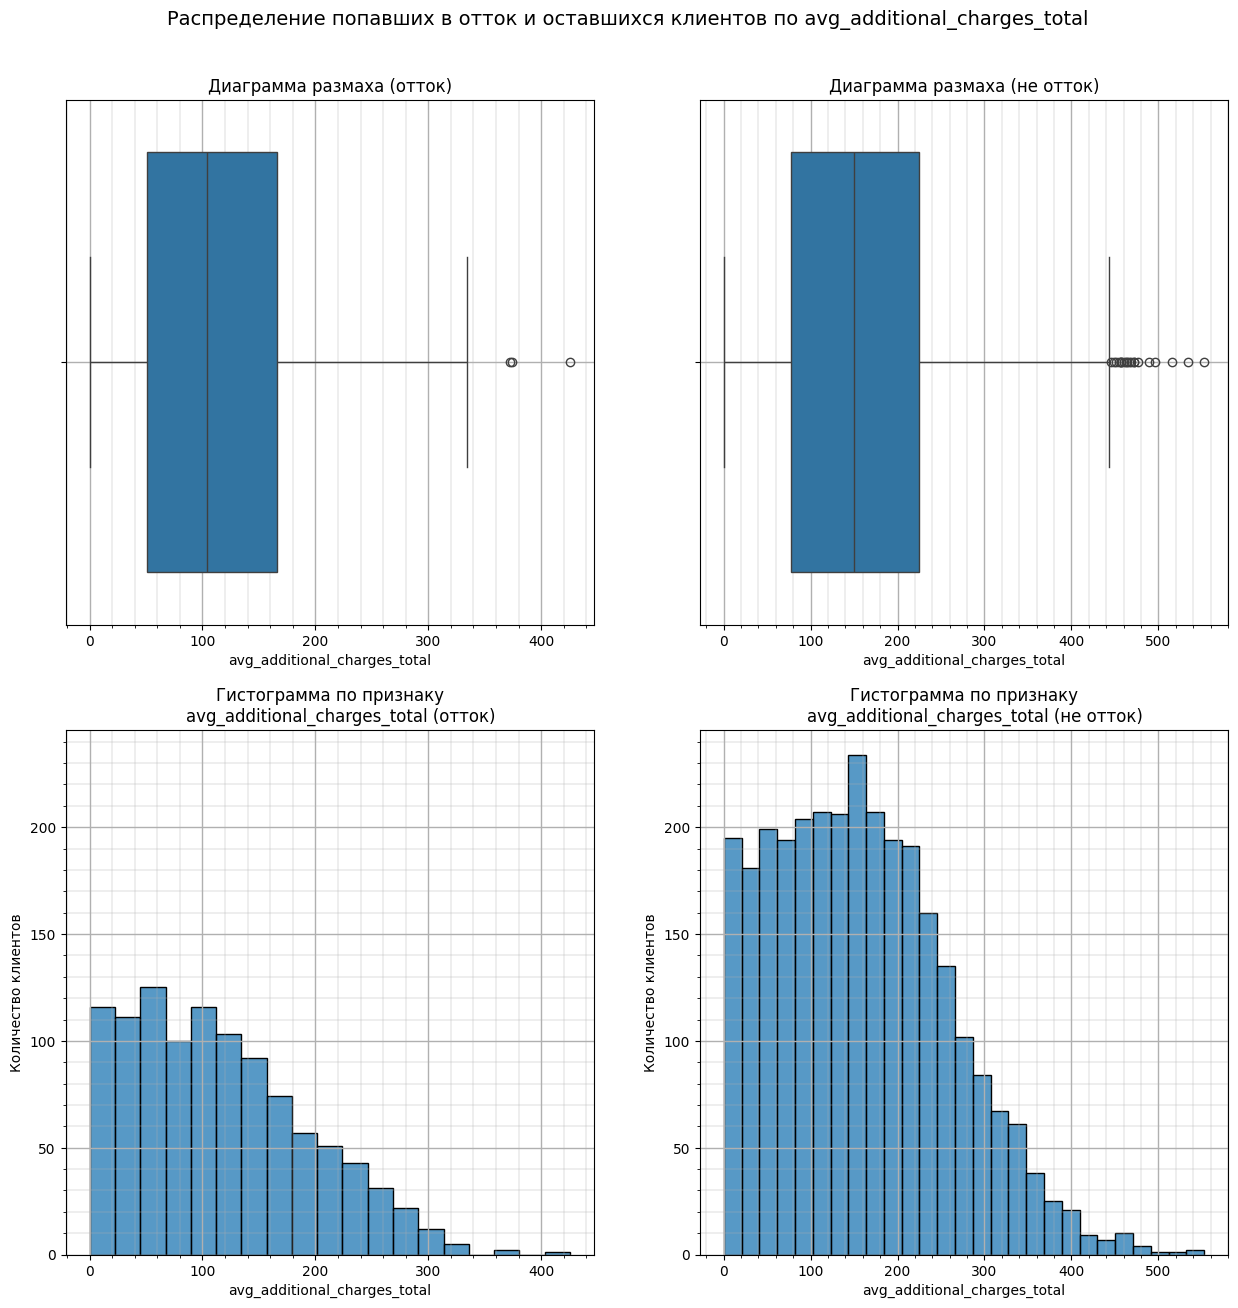

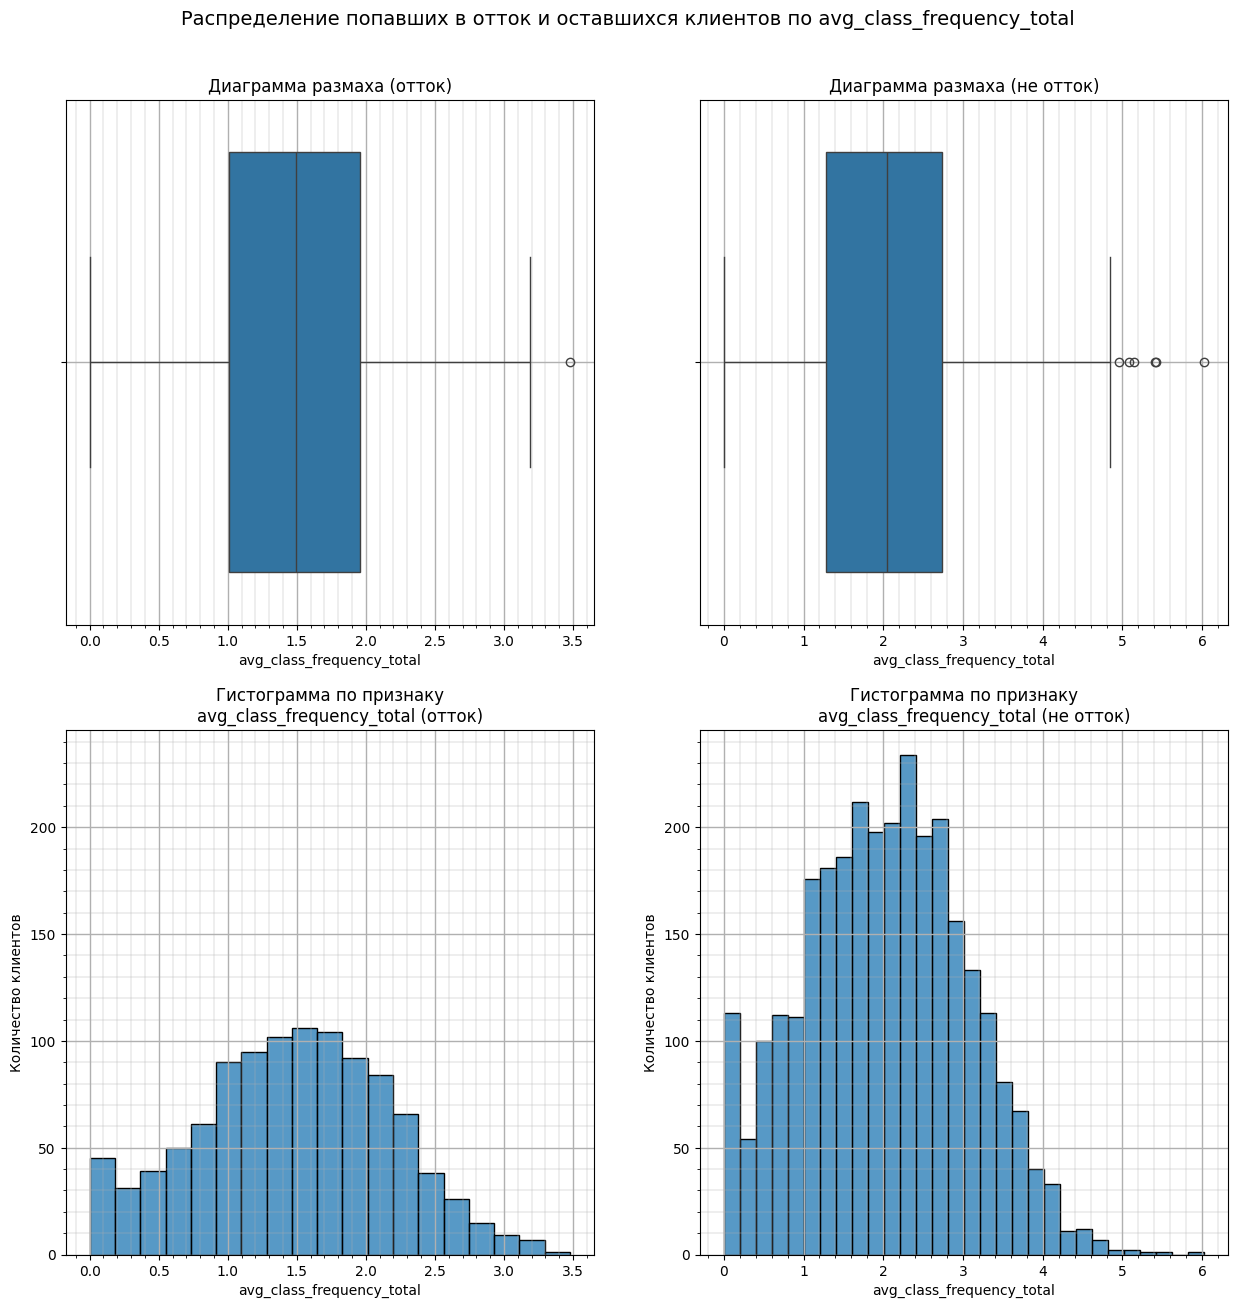

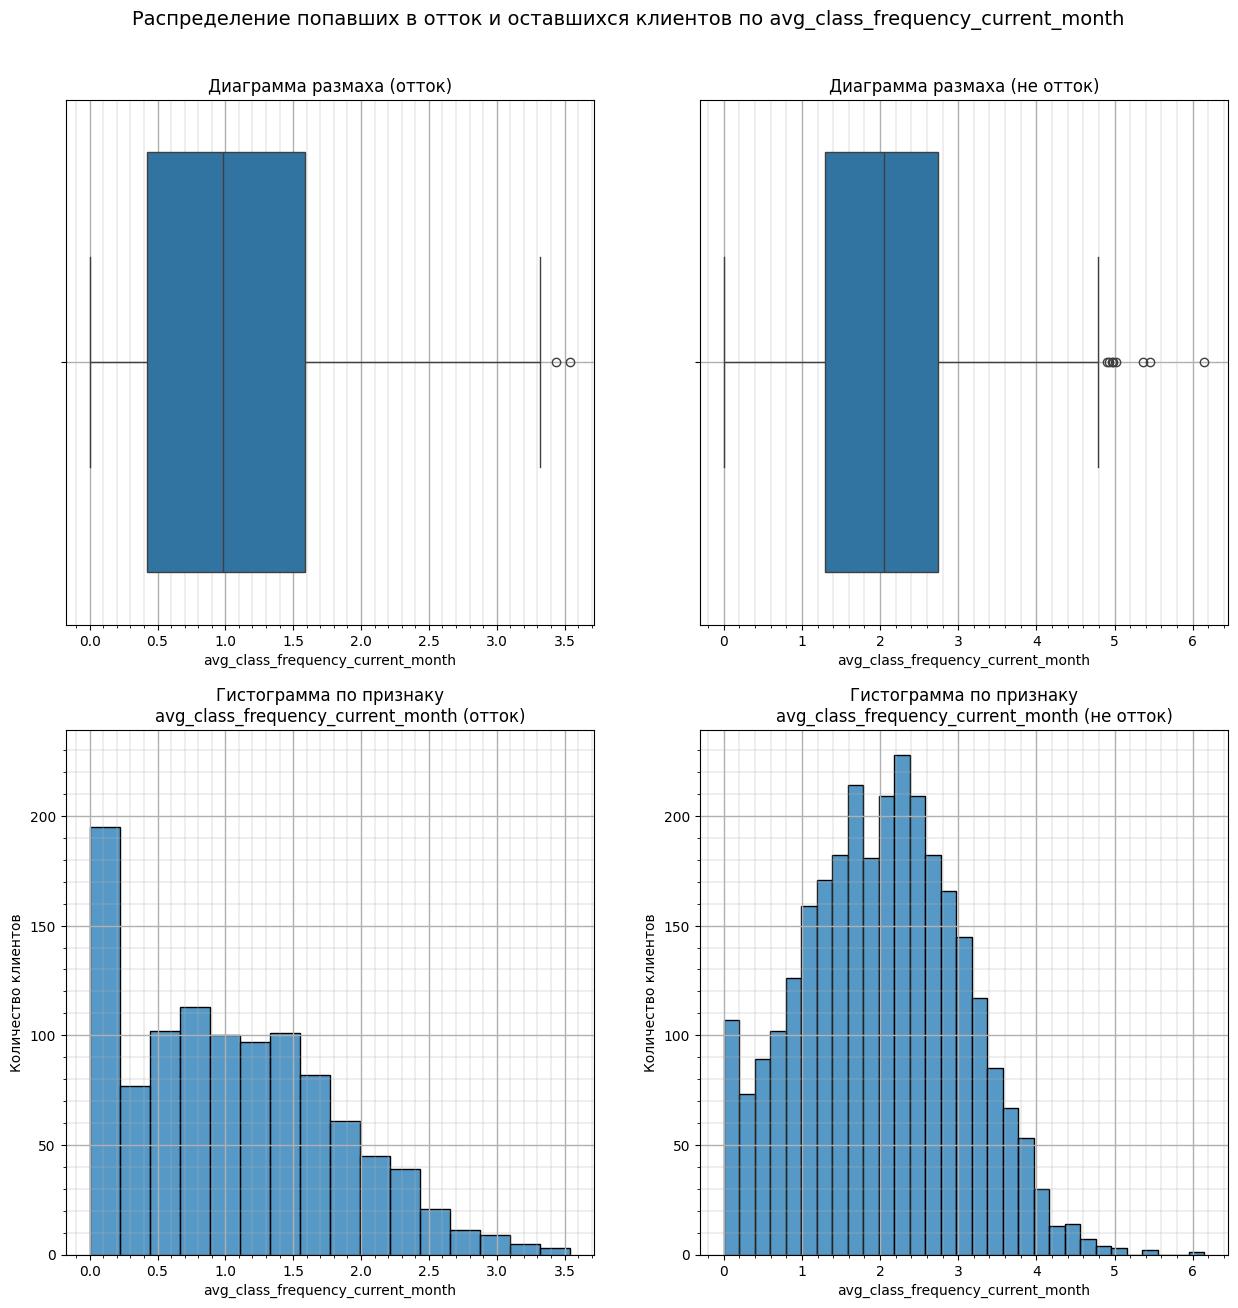

In [ ]:
for feature in continuous_value:

    fig=plt.figure(figsize=(15, 15))
    fig.suptitle(f'Распределение попавших в отток и оставшихся клиентов по {feature}', y=0.94, size=14)

    ax1=plt.subplot(2, 2, 1)
    sns.boxplot(data=data.query('churn==1'), x=feature, ax=ax1)
    ax1.set_title(f'Диаграмма размаха (отток)', size=12)
    ax1.set_xlabel(f'{feature}', size=10)
    ax1.grid(True, which = "major", linewidth = 1)
    ax1.grid(which = "minor", linewidth = 0.3)
    ax1.minorticks_on()

    ax2=plt.subplot(2, 2, 3)
    sns.histplot(data=data.query('churn==1'), x=feature, ax=ax2)
    ax2.set_title(f'''Гистограмма по признаку
    {feature} (отток)''', size=12)
    ax2.set_xlabel(f'{feature}', size=10)
    ax2.set_ylabel('Количество клиентов', size=10)
    ax2.grid(True, which = "major", linewidth = 1)
    ax2.grid(which = "minor", linewidth = 0.3)
    ax2.minorticks_on()

    ax3=plt.subplot(2, 2, 2)
    sns.boxplot(data=data.query('churn==0'), x=feature, ax=ax3)
    ax3.set_title(f'Диаграмма размаха (не отток)', size=12)
    ax3.set_xlabel(f'{feature}', size=10)
    ax3.grid(True, which = "major", linewidth = 1)
    ax3.grid(which = "minor", linewidth = 0.3)
    ax3.minorticks_on()

    ax4=plt.subplot(2, 2, 4, sharey=ax2)
    sns.histplot(data=data.query('churn==0'), x=feature, ax=ax4)
    ax4.set_title(f'''Гистограмма по признаку
    {feature} (не отток)''', size=12)
    ax4.set_xlabel(f'{feature}', size=10)
    ax4.set_ylabel('Количество клиентов', size=10)
    ax4.grid(True, which = "major", linewidth = 1)
    ax4.grid(which = "minor", linewidth = 0.3)
    ax4.minorticks_on()
    plt.show()

*В результате изучения графиков распределения признаков с непрерывными величинами аномальные выбросы не выявлены.*

**В отток ушли** *клиенты, тратившие меньше денег на доп.услуги фитнес-центра, со средней частотой посещений 1,5 тренировки в неделю, в последний месяц ходят в среднем только 1 раз.*

**Продолжили занятия в клубе** *клиенты, тратившие больше денег на доп.услуги фитнес-центра. У продолжающих тренировки частота остаеся без изменений - в среднем 2 раза в неделю.*

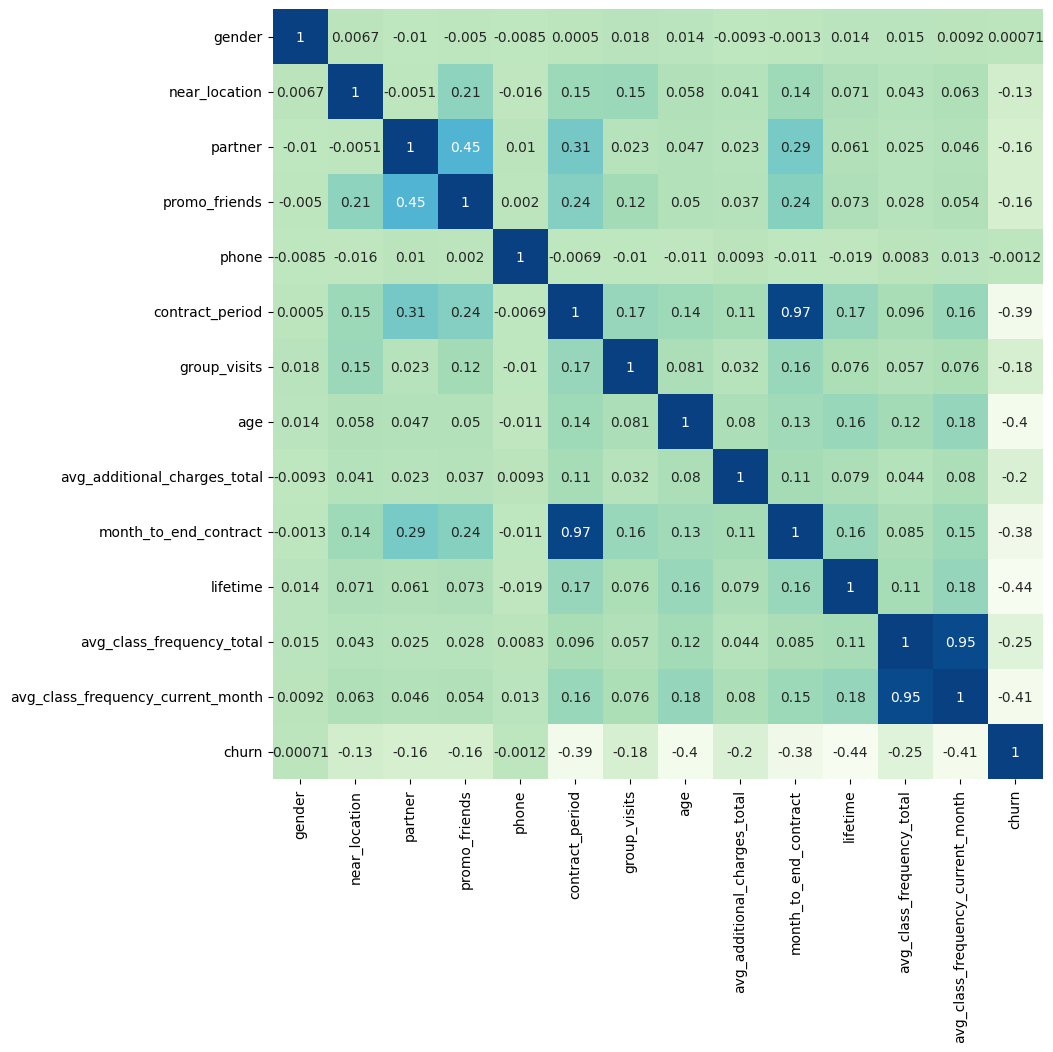

In [ ]:
# построим матрицу корреляций и отобразим её
cm = data.corr()
fig, ax = plt.subplots(figsize=(10, 10))

# нарисуем тепловую карту для матрицы корреляций
sns.heatmap(cm, annot=True, cmap='GnBu', square=True, cbar=False)
plt.show()

*У целевой переменной со всеми признаками слабая или средняя отрицательная корреляция.*

*Очень высокая положительная корреляция между следующими признаками:*

*- длительность текущего действующего абонемента и срок до окончания текущего действующего абонемента (0,97)*

*- средняя частота посещений в неделю за все время с начала действия абонемента и  средняя частота посещений в неделю за предыдущий месяц (0,95)*

**В случае применения линейных моделей нам необходимо будет удалить один из коррелирующих признаков для исключения мультиколлинеарности.**

**Вывод по разделу "Проведение исследовательского анализа данных (EDA)":**
1. В результате изучения распределения признаков аномальные выбросы не выявлены
2. По графикам распределения значений признаков можем предположить, что к оттоку склонны более молодые люди 25-29 лет с общей продолжительностью посещения клуба в течение 1 месяца, с абонементом на 1 месяц и сроком окончания абонемента через 1 месяц, тратившие меньше денег на доп.услуги фитнес-центра, со средней частотой посещений 1,5 тренировки в неделю, за последний месяц  только 1 раз в неделю.
3. Чаще продолжают занятия в фитнес-центре клиенты в возрасте 28-32 года, посещающие клуб в течение 2-6 месяцев с приобретенными абонементами на разные периоды (1, 3, 6 мес.), тратившие больше денег на доп.услуги фитнес-центра и со средней частотой тренировок 2 раза в неделю.
4. Установлена очень высокая положительная корреляция между признаками: длительность текущего действующего абонемента и срок до окончания текущего действующего абонемента; средняя частота посещений в неделю за все время с начала действия абонемента и  средняя частота посещений в неделю за предыдущий месяц. В случае применения линейных моделей необходимо будет удалить один из коррелирующих признаков для исключения мультиколлинеарности.

## Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где **целевой признак — факт оттока** клиента в следующем месяце. Для этого разобьем данные на обучающую и валидационную выборку функцией `train_test_split()`. Обучим модель на train-выборке двумя способами: логистической регрессией, случайным лесом. Затем оценим метрики `accuracy`, `precision` и `recall` для обеих моделей на валидационной выборке. Сравним по ним модели.

In [ ]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(columns=['churn'])
y = data['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
# обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train)

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

# задаем список моделей
models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(random_state=0)
]

# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    # обучим модель
    model.fit(X_train, y_train)
    # прогноз
    predictions = model.predict(X_test)
    accuracy=accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    print(
        'accuracy:{:.4f} precision:{:.4f} recall:{:.4f} '.format(
            accuracy,
            precision,
            recall
        )
    )

# цикл, который выводит метрики по списку моделей
for m in models:
    print(m)
    make_prediction(m, X_train_st, y_train, X_test_st, y_test)



LogisticRegression(random_state=0)
accuracy:0.9225 precision:0.8542 recall:0.8283 
RandomForestClassifier(random_state=0)
accuracy:0.9150 precision:0.8385 recall:0.8131 


Условие, которому должны удовлетворять данные для алгоритма логистической регрессии такие же, как и для линейной регрессии: между признаками (независимыми входными переменными) **не должно быть мультиколлинеарности**.

Была установлена очень высокая положительная корреляция между следующими признаками: длительность текущего действующего абонемента и срок до окончания текущего действующего абонемента (коэффициент корреляции 0,97); средняя частота посещений в неделю за все время с начала действия абонемента и средняя частота посещений в неделю за предыдущий месяц (0,95). В всязи с этим создадим новый датафрейм  `data_without_corr`, удалив из него два признака, являющиеся следствием других признаков: `срок до окончания текущего действующего абонемента`, `средняя частота посещений в неделю за предыдущий месяц`

Алгоритм ансамбля деревьев устойчив к мультиколлинеарности.

In [ ]:
# сделаем перерасчет модели логистической регрессии после удаления одного из признака с высокой корреляцией
data_without_corr = data.drop(columns=['month_to_end_contract', 'avg_class_frequency_current_month'])
X = data_without_corr.drop(columns=['churn'])
y = data_without_corr['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)
model = LogisticRegression(random_state=0)
model.fit(X_train_st, y_train)
predictions = model.predict(X_test_st)
accuracy=accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
print('accuracy:{:.4f} precision:{:.4f} recall:{:.4f} '.format(accuracy, precision, recall))

accuracy:0.8988 precision:0.7882 recall:0.8081 


*Перерасчет модели логистической регрессии показал по всем метрикам результаты хуже чем, до удаления коррелирующих признаков. Откажемся от удаления коррелирующих признаков.*

*По трем расчитанным метрикам `accuracy`, `precision`, `recall` результаты лучше показал алгоритм LogisticRegression: доля правильных ответов - 92,25%, точность (доля верных прогнозов относительно 1-го класса) - 85,42% и полнота (доля реальных объектов 1-го класса, которые смогли обнаружить с помощью модели) - 82,83%.*

*У алгоритма RandomForestClassifier доля правильных ответов - 91,5%, точность - 83,85% и полнота - 81,31%.*

**Вывод по разделу "Построение модели прогнозирования оттока клиентов":**
1. Построили модель бинарной классификации клиентов по целевому признаку — факту оттока клиента в следующем месяце.
2. Обучили модель на train-выборке двумя способами: логистической регрессией (LogisticRegression), случайным лесом (RandomForestClassifier).
3. По трем метрикам accuracy, precision, recall результаты лучше показал алгоритм LogisticRegression: доля правильных ответов - 92,25% (у RandomForestClassifier - 91,5%), точность - 85,42% (у RandomForestClassifier - 83,85%) и полнота - 82,83% (у RandomForestClassifier - 81,31%).

## Проведение кластеризации клиентов

Подготовим и стандартизируем данные для кластеризации клиентов

In [ ]:
# удалим из данных столбец с оттоком
data_for_cluster = data.drop(columns=['churn'])
# создадим объект scaler класса StandardScaler
scaler = StandardScaler()
# обучаем scaler и одновременно трансформируем матрицу признаков
X_sc = scaler.fit_transform(data_for_cluster)

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму для клиентов клуба

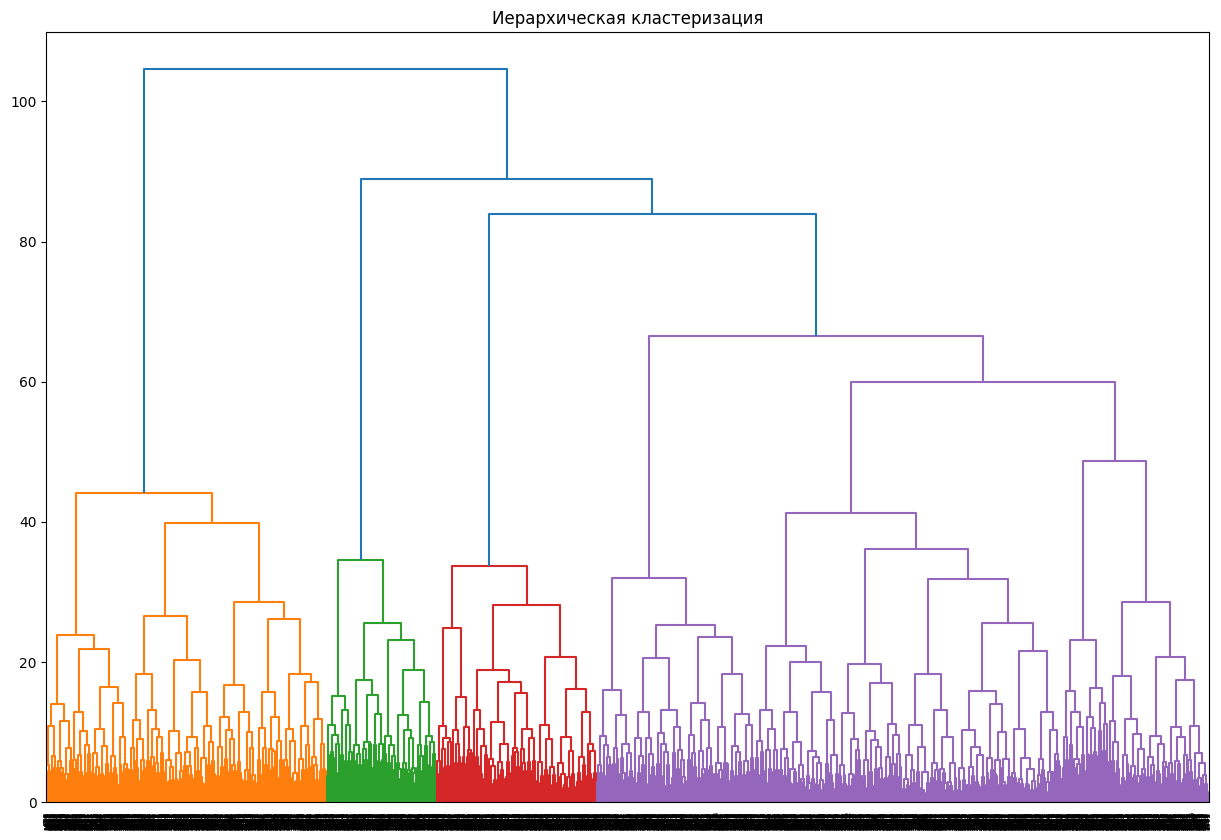

In [ ]:
# посторим матрицу расстояний на стандартизованной матрице признаков
linked = linkage(X_sc, method = 'ward')
# нарисуем дендрограмму
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

*На основании полученного графика предложено оптимальное число кластеров - 4 (4 разных цвета на графике)*

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов (за число кластеров по условиям задания принимаем n_clusters=5)

In [ ]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
model_k_means = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = model_k_means.fit_predict(X_sc)

In [ ]:
# сохраняем метки кластера в поле нашего исходного датасета
data['cluster_client'] = labels

Построим распределения признаков для кластеров

In [ ]:
# подготовим списки признаков для визуализации распределения
boolean_value = [
    'gender',
    'near_location',
    'partner',
    'promo_friends',
    'phone',
    'group_visits'
]

In [ ]:
numeric_value = [
    'age',
    'lifetime',
    'contract_period',
    'month_to_end_contract',
    'avg_additional_charges_total',
    'avg_class_frequency_total',
    'avg_class_frequency_current_month'
]

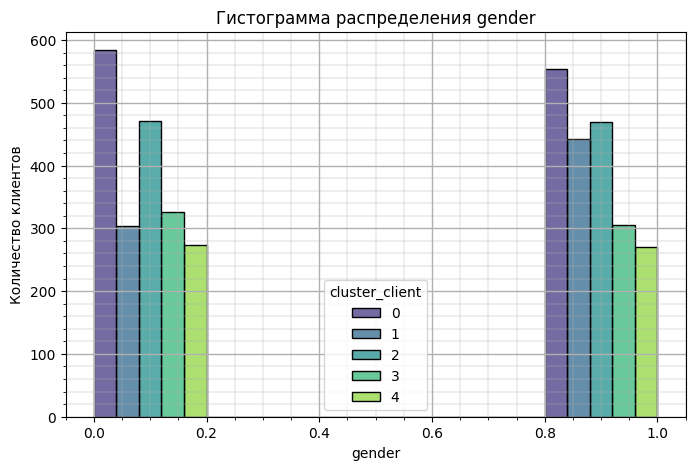

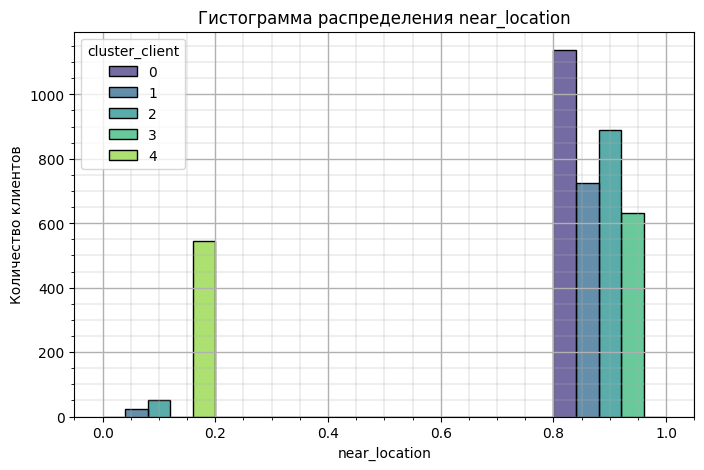

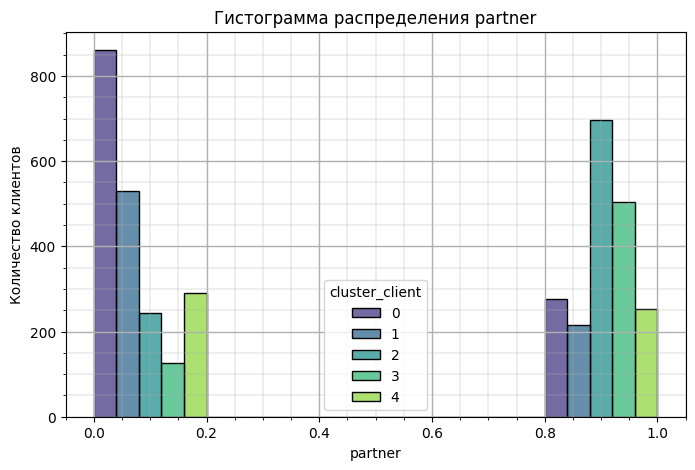

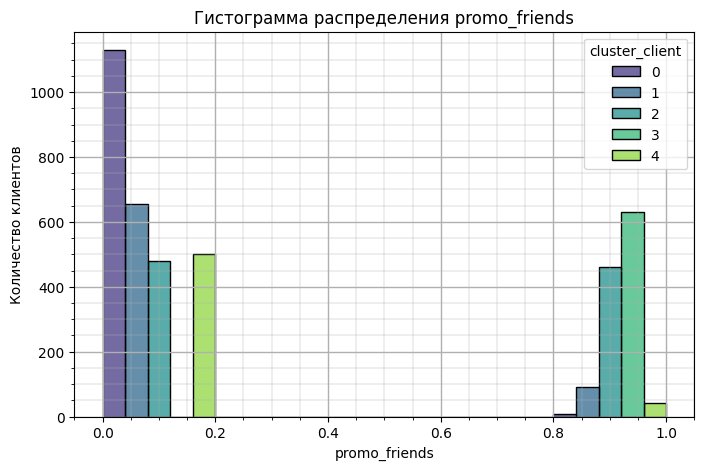

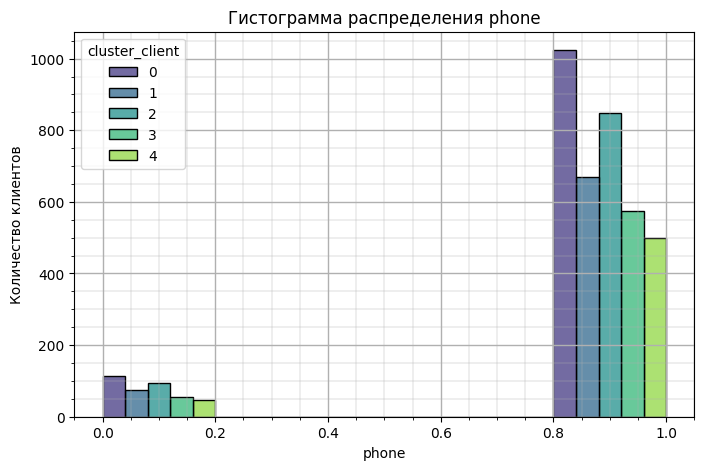

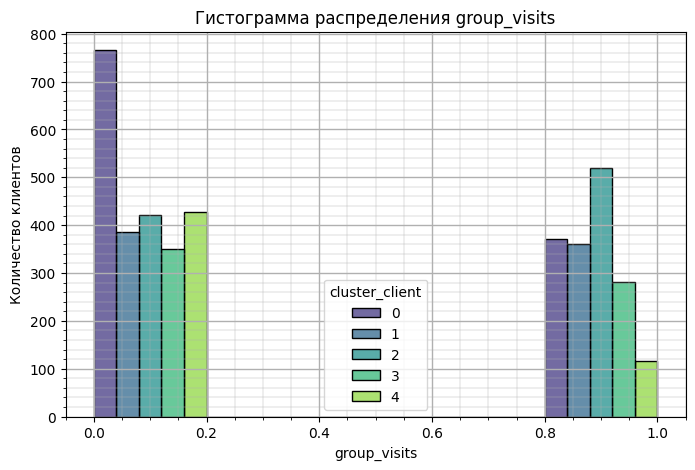

In [ ]:
# построим распределения по кластерам признаков с логическими данными
for i in boolean_value:
    ax=sns.histplot(
        data=data,
        x=i,
        hue='cluster_client',
        multiple='dodge',
        binwidth=0.2,
        palette=sns.color_palette('viridis', 5)
    )
    ax.set_title(f'Гистограмма распределения {i}', size=12)
    ax.set_xlabel(i, size=10)
    ax.set_ylabel('Количество клиентов', size=10)
    ax.grid(True, which = "major", linewidth = 1)
    ax.grid(which = "minor", linewidth = 0.3)
    ax.minorticks_on()
    plt.show()

*По **половому признаку** нет выраженного распределения по кластерам, только в 4-ом кластере числу мужчин больше женщин. По **территориальному проживанию** клиенты во всех кластерах, кроме 2, проживают рядом с клубом. Сотрудников **компаний-партнеров** больше всего в 0-ом кластере, меньше всего в 3-ем. В 0-ом кластере больше всего клиентов, воспользовавшихся промо-кодом от знакомого. **Номера телефонов** не заполнили только клиенты из 1-го кластера. **Групповые занятия** больше посещают в 0-ом кластере.*

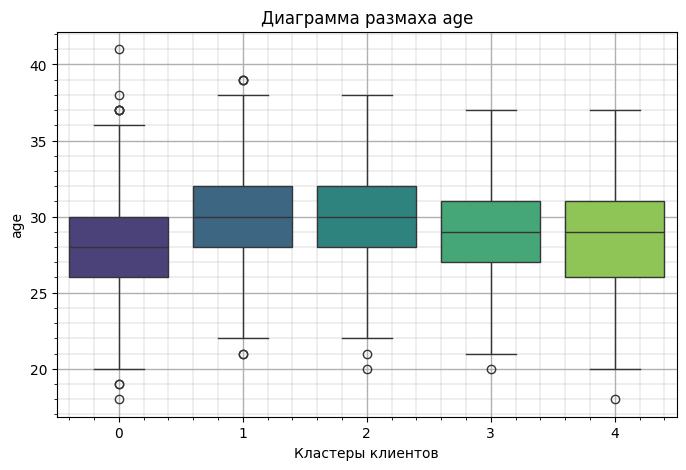

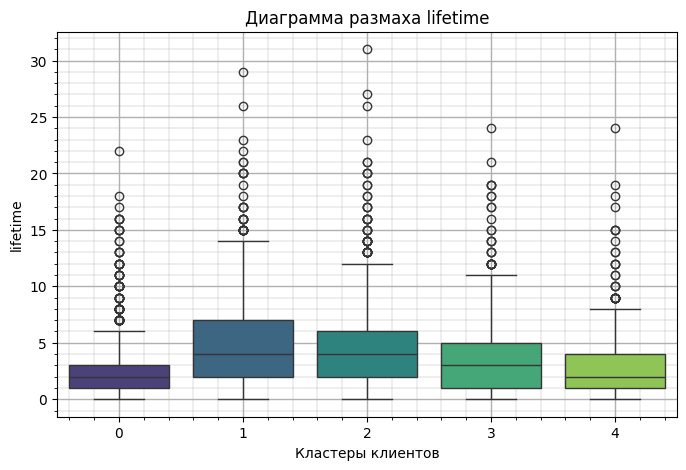

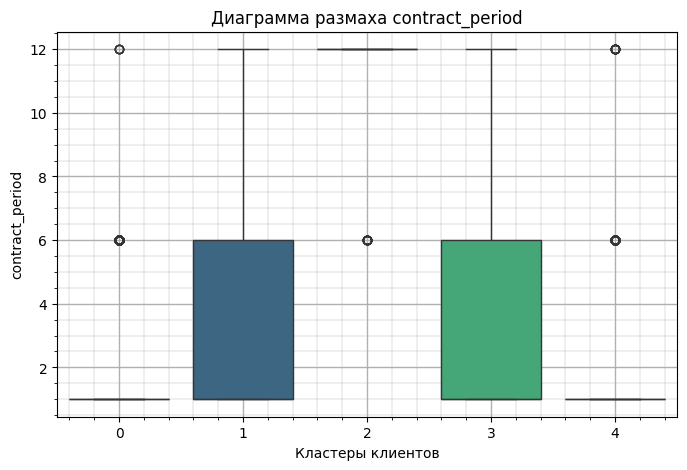

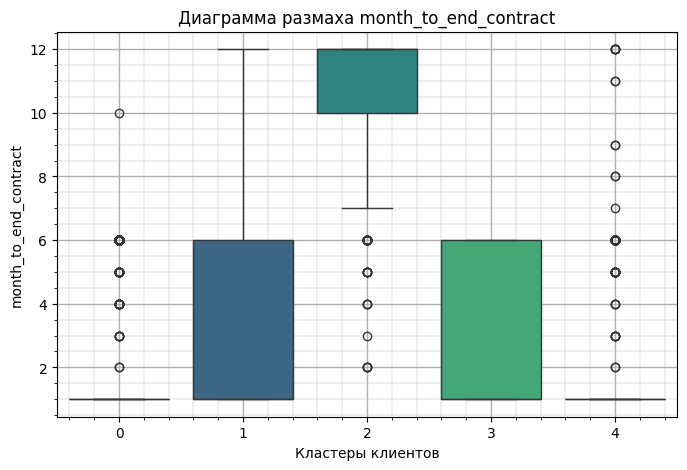

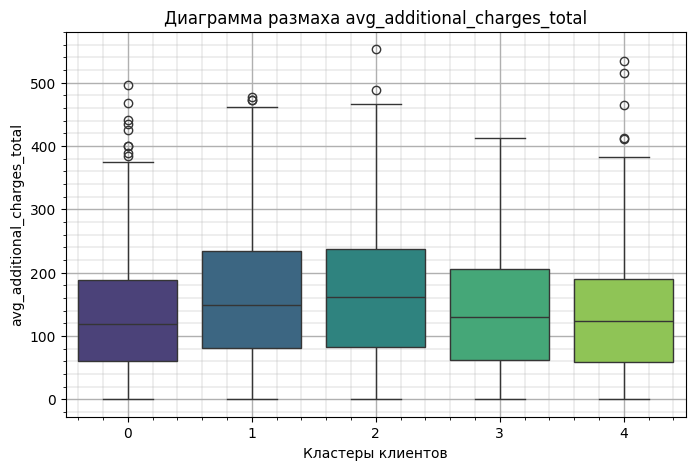

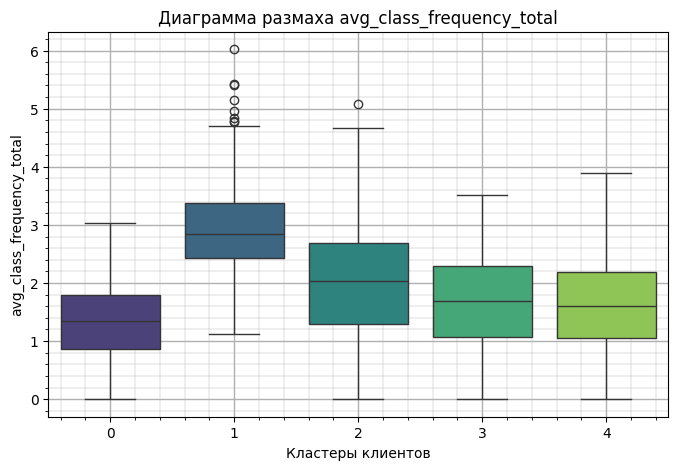

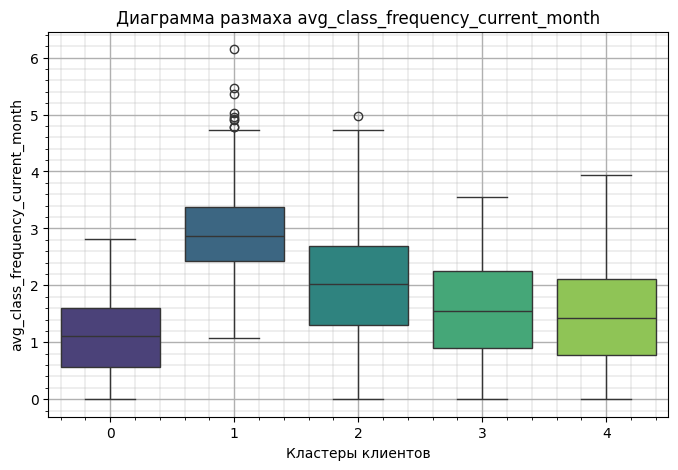

In [ ]:
# построим распределения по кластерам признаков с числовыми данными
for i in numeric_value:
    ax=sns.boxplot(
        data=data,
        x='cluster_client',
        y=i,
        palette=sns.color_palette('viridis', 5)
    )
    ax.set_title(f'Диаграмма размаха {i}', size=12)
    ax.set_xlabel('Кластеры клиентов', size=10)
    ax.set_ylabel(i, size=10)
    ax.grid(True, which = "major", linewidth = 1)
    ax.grid(which = "minor", linewidth = 0.3)
    ax.minorticks_on()
    plt.show()

*По **возрасту** самые молодые клиенты в кластере № 3, самые возрастные в кластерах № 0 и 4. **Lifetime** самая непродолжительная в кластере № 3, самая длительная в кластерах № 0, 4. Самые продолжительные **абонементы** на 12 мес. в 0-ом кластере, самые непродолжительные 1 мес. в 2 и 3 кластерах. Значительные **траты на допуслуги** фитнесцентра у 0 и 4 кластеров. Самая высокая частота тренировок у 4 и 0 кластеров, самая низкая у 3 кластера.*

Посмотрим на средние значения признаков и долю оттока для кластеров

In [ ]:
# выводим статистику по средним значениям наших признаков и долю оттока по кластеру
data.groupby('cluster_client').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_client,,,,,,,,,,,,,,
0,0.49,1.00,0.24,0.01,0.90,1.98,0.33,28.24,130.88,1.90,2.48,1.32,1.08,0.51
1,0.59,0.97,0.29,0.12,0.90,2.90,0.48,30.34,164.19,2.65,5.22,2.94,2.94,0.05
2,0.50,0.94,0.74,0.49,0.90,11.87,0.55,29.91,165.15,10.85,4.74,1.99,1.98,0.02
3,0.48,1.00,0.80,1.00,0.91,3.08,0.45,29.05,139.86,2.87,3.51,1.67,1.55,0.27
4,0.50,0.00,0.47,0.08,0.92,2.21,0.22,28.48,133.63,2.07,2.78,1.66,1.47,0.45


In [ ]:
# подсчитаем количество клиентов в каждом кластере
data.groupby('cluster_client')['gender'].count()

,gender
cluster_client,
0,1138
1,746
2,941
3,631
4,544


In [ ]:
# выведем долю оттока для каждого кластера в отдельную таблицу
data.pivot_table(
    index='cluster_client',
    values='churn',
    aggfunc='mean').sort_values(by='churn', ascending=False).style.background_gradient()

,churn
cluster_client,
0,0.513181
4,0.450368
3,0.269414
1,0.054960
2,0.022317


- Самый сильный **отток в кластере № 3 - 51%**. Для кластера № 3 характерно, что все эти клиенты проживают вблизи спортклуба, в этой группе меньше всего сотрудников компаний-партнеров (35%), в среднем самые короткие абонементы (1,95 мес.), самый молодой средний возраст 28 лет, самые маленькие траты на допуслуги, самый короткий lifetime (2,4 мес.) и самая редкая частота посещений тренировок (1,25 раз в неделю). Это самая многочисленная группа - 1262 клиента.

- Отток в **кластере № 2 - 44%**, здесь отсутсвуют проживающие вблизи спортклуба, все эти клиенты приезжают из других районов города, почти не имеют друзей в спортклубе (применили промо-код от знакомого только 8%), меньше всего в среднем посещают групповые занятия (22%). Скорее всего ходят в клуб рядом с местом работы.

- Отток в **кластере № 1 - 27%**, здесь ни один клиент не оставил в анкете номер своего телефона - очевидно нежелание иметь обратную связь от клуба, самый маленький по численности кластер (385 чел.).

- **В кластере № 4 отток - 7%** здесь самый высокий средний возраст, в нем больше всего мужчин (56%), проживание рядом с клубом (98%), самые высокие траты на допуслуги, самая длинный lifetime (4,9 мес.), самая высокая частота тренировок (2-3 раза в нед.), не изменяющаяся со временем.

- Самый низкий отток в **кластере № 0 - 3%** здесь также высокое число проживающих рядом (96%), среди них больше всего сотрудников компаний-партнеров (78%) и самое высокое число клиентов, применивших промо-код от знакомого (57%), самые длинные абонементы (11 мес.), самая высокая частота посещения групповых занятий (54%), высокие траты на допуслуги, продолжительная lifetime (4,7 мес.), высокая частота тренировок (2 раза в нед.), не изменяющаяся со временем. Многочисленная группа - 1010 клиентов.

**Вывод по разделу "Проведение кластеризации клиентов":**
1. Проведена кластеризация клиентов на основании алгоритма K-Means.
2. **Выявлены самые ненадежные кластеры № 3 (1262 клиента) - отток 51%, № 2 (505 клиентов) - отток 44%.**
2. Для кластера № 3 характерно, что все эти клиенты проживают вблизи спортклуба, в этой группе меньше всего сотрудников компаний-партнеров, в среднем самые короткие абонементы, самый молодой средний возраст, самые маленькие траты на допуслуги, самый короткий lifetime и самая редкая частота посещений тренировок. Это самая многочисленная группа.
3. В кластере № 2 отсутсвуют проживающие вблизи спортклуба, все эти клиенты приезжают из других районов города, почти не имеют друзей в спортклубе, меньше всего в среднем посещают групповые занятия. Скорее всего ходят в клуб рядом с местом работы.
4. **Самые надежные кластеры № 0 (1010 клиентов) - отток 3%, № 4 (838 клиентов) - отток 7%.**
5. В кластере № 0 высокое число клиентов, проживающих рядом, среди них больше всего сотрудников компаний-партнеров и самое высокое число клиентов, применивших промо-код от знакомого, самые длинные абонементы, самая высокая частота посещения групповых занятий, высокие траты на допуслуги, продолжительная lifetime, высокая частота тренировок), не изменяющаяся со временем.
6. В кластере № 4 самый высокий средний возраст, в нем больше всего мужчин, большинство проживает рядом с клубом, самые высокие траты на допуслуги, самая длинный lifetime, самая высокая частота тренировок, не изменяющаяся со временем.

## Подготовка рекомендаций по работе с клиентами

В ходе проведенного исследования данных сети фитнес-центров «Культурист-датасаентист» на предмет оттока клиентов установлены две наболее надежные группы клиентов с низким процентом оттока. Так как удержания этих клиентов на достаточном уровне, здесь нужно разработать стратегию **по увеличению численности этих групп**.

Первая надежная группа - это клиенты, проживающих рядом, являющиеся сотрудниками компаний-партнеров клуба, многие из этих клиентов применили промо-коды от знакомых, у них самые длинные абонементы, самая высокая частота посещения групповых занятий, высокие траты на допуслуги, продолжительная lifetime и высокая частота тренировок, не изменяющаяся со временем.

**Рекомендация для первой надежной группы:**
Привлечь еще больше сотрудников этих компаний-партнеров - провести рекламные кампании в этих организациях (распространить рекламные буклеты, предоставить скидки к приближающемуся празнику, напимер 8 марта) или предложить компании-партнеру свою площадку для проведения закрытых спортивных мероприятий, чтобы другие сотрудники побывали на территории фитнесцентра, а в качестве подарков победителям можжно предложить купоны со скидкой на приобретение абонементов. Также можно поискать новые организации, которые находятся территориально недаленко от клуба, и предложить им сотрудничество.

Вторая надежная группа - это клиенты с самый высоким средним возрастом, в этой группе больше мужчин, большинство проживает рядом с клубом, самые высокие траты на допуслуги, самая длинный lifetime и самая высокая частота тренировок, не изменяющаяся со временем. Скорее всего, это группа более взрослых людей, следящих за своим здоровьем, физическим состоянием и фигурой, финансово благополучная, возможно бывшие спортсмены.

**Рекомендация для второй надежной группы:**
В качестве рекомендаций для этой группы можно предложить расширение комплекса допуслуг - услуги массажиста, косметолога, сауна, солярий. Или попробовать предложить нетривиальные для фитнесцентров тренировки, например, бокс.

Также установлены две наиболее подверженные к оттоку группы клиентов. Здесь нужно разработать стратегию **по удержанию клиентов**.

Первая ненадежная группа - это молодые люди, все они проживают вблизи спортклуба, среди них меньше всего сотрудников компаний-партнеров, в среднем самые короткие (= дешевые) абонементы, самые маленькие траты на допуслуги, самый короткий lifetime и самая редкая частота посещений тренировок.

**Рекомендация для первой ненадежной группы:**
Для молодых людей, пока не стабильных финансово, следует предложить скидки на абонементы, например, для школьников и студентов ВУЗов.

Вторая ненадежная группа - клиенты, приезжающие из других районов города, почти не имеют друзей в спортклубе, меньше всего в среднем посещают групповые занятия, скорее всего ходят в клуб рядом с местом работы.

**Рекомендация для второй ненадежной группы:**
Следует попытаться узнать место работы этих клиентов (провести анкетирование или интервьюирование) для того, чтобы предложить этим организациям сотрудничество, тогда сотрудники этих компаний смогут получать скидки на абонемент.